# Assignment: Retail Giant Forecasting Assignment

# Business Statement: 
Global Mart is an online supergiant store that has worldwide operations. This store takes orders and delivers across the globe and deals with all the major product categories — consumer, corporate and home office.

 - Geographically, it supplies to 7 Market regions 
 - Demographically, it supplies to 3 Segments. 
 - A Total of 21 unique Market-segments are being catered by the Retail giant. 

## Objective: 
- 1. To find out the most profitable market segment with the help of metric called Coefficient of Variance
- 2. The most profitable market segment should be divided into 42 months of training data and 6 months of test data on the basis of sales.
- 3. Forecast sales using following methods/techniques on the test set
    - <b>Smoothing Methods:</b> 
         - a) Simple Exponential Smoothing
         - b) Holt's Exponential Smoothing
         - c) Holt's Winter Exponential Smoothing/Additive Seasonal Trend
         - d) Holt's Winter Exponential Smoothing/Multiplicative Seasonal Trend
     - <b>ARIMA Methods:</b>
         - a) Auto Regresssion (AR)
         - b) Moving Average (MA)
         - c) Autoregressive Moving Average (ARMA)
         - d) Autoregressive Integrated Moving Average (ARIMA)
         - e) Seasonal Autoregressive Integrated Moving Average (SARIMA)
- 4. Find out which smoothing method is the most efficient and which ARIMA method is the most efficient in terms of forecasting

## Step 1: <u> Data Preparation </u>

In [1]:
## Import all the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Import warnings library
import warnings
warnings.filterwarnings("ignore")

In [3]:
## Reading the dataset
df = pd.read_csv("Global+Superstore+Data.csv", parse_dates=['Order Date'], dayfirst=True)
df.head()

,Order Date,Segment,Market,Sales,Profit
0,2012-07-31,Consumer,US,2309.650,762.1845
1,2013-02-05,Corporate,APAC,3709.395,-288.7650
2,2013-10-17,Consumer,APAC,5175.171,919.9710
3,2013-01-28,Home Office,EU,2892.510,-96.5400
4,2013-11-05,Consumer,Africa,2832.960,311.5200


In [4]:
## Printing the concise summary of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  51290 non-null  datetime64[ns]
 1   Segment     51290 non-null  object        
 2   Market      51290 non-null  object        
 3   Sales       51290 non-null  float64       
 4   Profit      51290 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 2.0+ MB


In [5]:
## Creating a column by concatenating market and segment column 
df.insert(0, "Market-Segment", df["Market"] + "-" + df["Segment"] )

df.head()

,Market-Segment,Order Date,Segment,Market,Sales,Profit
0,US-Consumer,2012-07-31,Consumer,US,2309.650,762.1845
1,APAC-Corporate,2013-02-05,Corporate,APAC,3709.395,-288.7650
2,APAC-Consumer,2013-10-17,Consumer,APAC,5175.171,919.9710
3,EU-Home Office,2013-01-28,Home Office,EU,2892.510,-96.5400
4,Africa-Consumer,2013-11-05,Consumer,Africa,2832.960,311.5200


In [6]:
## Converting the Order Date Column into datetime format of Month-Year
df['Order Date'] = pd.to_datetime(df['Order Date']).dt.to_period('M')

### Sort the values in ascending order starting from Jan-2011 and ending at Dec-2014
df= df.sort_values(by=['Order Date'])
df.head()

,Market-Segment,Order Date,Segment,Market,Sales,Profit
30643,LATAM-Consumer,2011-01,Consumer,LATAM,60.9600,28.6400
48527,US-Consumer,2011-01,Consumer,US,19.3000,5.7900
29861,APAC-Home Office,2011-01,Home Office,APAC,51.6285,4.5885
29871,LATAM-Consumer,2011-01,Consumer,LATAM,47.9600,15.8000
16508,APAC-Consumer,2011-01,Consumer,APAC,176.6808,-156.6792


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51290 entries, 30643 to 44106
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype    
---  ------          --------------  -----    
 0   Market-Segment  51290 non-null  object   
 1   Order Date      51290 non-null  period[M]
 2   Segment         51290 non-null  object   
 3   Market          51290 non-null  object   
 4   Sales           51290 non-null  float64  
 5   Profit          51290 non-null  float64  
dtypes: float64(2), object(3), period[M](1)
memory usage: 2.7+ MB


In [8]:
df.shape

(51290, 6)

In [9]:
print("Market Segments:", df["Market-Segment"].nunique())
print("Total Months:", df["Order Date"].nunique())

Market Segments: 21
Total Months: 48


## Step 2: <u>Exploratory Data Analysis</u>

In [10]:
## Creating a deep copy of the original file to perform EDA on df_eda dataframe
df_eda = df.copy(deep=True)

In [11]:
df_eda.head()

,Market-Segment,Order Date,Segment,Market,Sales,Profit
30643,LATAM-Consumer,2011-01,Consumer,LATAM,60.9600,28.6400
48527,US-Consumer,2011-01,Consumer,US,19.3000,5.7900
29861,APAC-Home Office,2011-01,Home Office,APAC,51.6285,4.5885
29871,LATAM-Consumer,2011-01,Consumer,LATAM,47.9600,15.8000
16508,APAC-Consumer,2011-01,Consumer,APAC,176.6808,-156.6792


### Outlier Detection

In [12]:
# Checking for outliers in the continuous variables
num_leads = df_eda[['Sales','Profit']]

# Checking outliers at 25%, 50%, 75%, 90%, 95% and 99%
num_leads.describe(percentiles=[.25, .5, .75, .90, .95, .99])

,Sales,Profit
count,51290.000000,51290.000000
mean,246.490581,28.610982
std,487.565361,174.340972
min,0.444000,-6599.978000
25%,30.758625,0.000000
50%,85.053000,9.240000
75%,251.053200,36.810000
90%,632.225736,112.680000
95%,1015.955640,211.500000
99%,2301.000000,587.359950


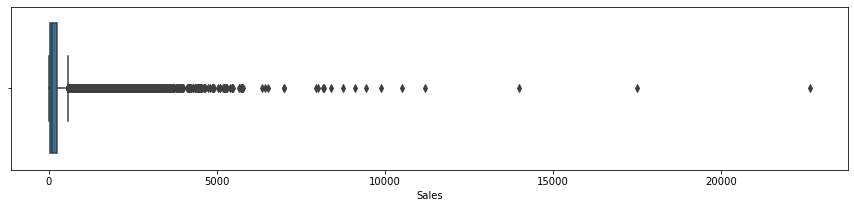

In [13]:
# Visualizing boxplots to see how the continuous variables are spread across the dataset and detecting if there are outliers
plt.figure(figsize=(15, 3))
sns.boxplot(x = df_eda['Sales'])
plt.show(block=False)

#### Inferences:
- 1. The Sales variable has extreme outliers, but this is possible as the transaction is completely online which allows customers with wide range of income groups to order products from the comfort of their homes.
- 2. The customers are not limited to a particular geography which is the main downside of traditional brick and mortar shops.

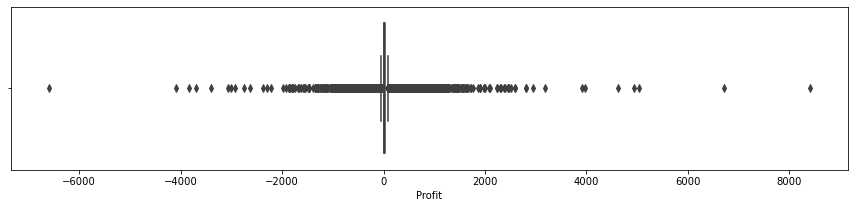

In [14]:
# Visualizing boxplots to see how the continuous variables are spread across the dataset and detecting if there are outliers
plt.figure(figsize=(15, 3))
sns.boxplot(x = df_eda['Profit'])
plt.show(block=False)

#### Inferences:
- 1. The Profit variable ranges from positive and negative values with extreme outliers at both ends
- 2. As Global Retail is an online business and supplies products to thousands of customers every year across the globe, customers have the option to replace the products if found faulty or there can be damage of goods caused by transportion  from point A to Point B which can lead to losses. 

###  Categorical Univariate Analysis

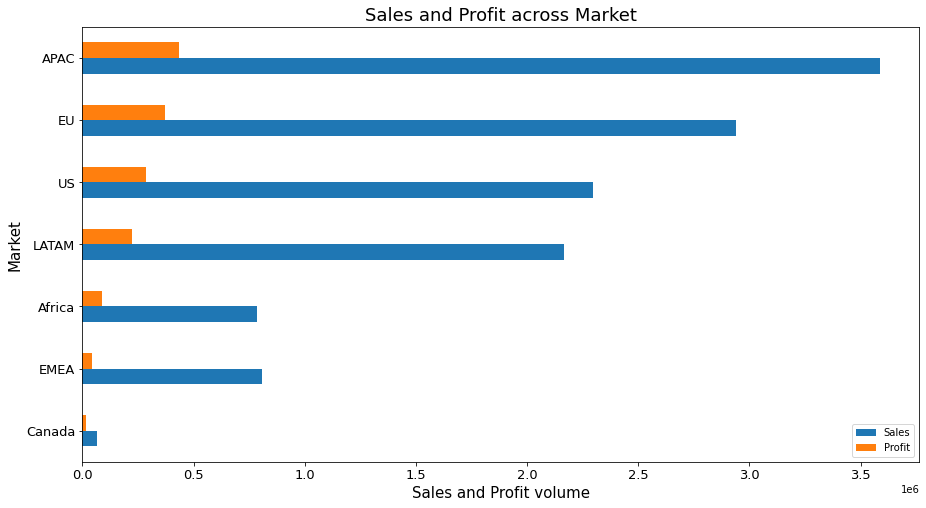

In [15]:
### Visualizing how sales and profit are distributed across 7 Markets

dfmsp= df_eda.groupby("Market")["Sales", "Profit"].sum()

dfmsp.sort_values(by="Profit", ascending=True, inplace=True)

ax = dfmsp.plot(kind='barh', figsize=(15,8), fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Sales and Profit across Market", fontsize=18)
ax.set_ylabel("Market", fontsize=15)
ax.set_xlabel("Sales and Profit volume", fontsize=15)
plt.show()

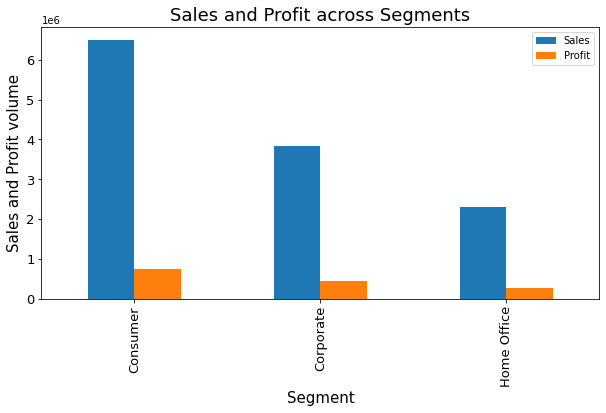

In [16]:
### Visualizing how sales and profit are distributed across 3 Segments

dfssp= df_eda.groupby("Segment")["Sales", "Profit"].sum()

dfssp.sort_values(by="Profit", ascending=False, inplace=True)

ax = dfssp.plot(kind='bar', figsize=(10,5), fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Sales and Profit across Segments", fontsize=18)
ax.set_ylabel("Sales and Profit volume", fontsize=15)
ax.set_xlabel("Segment", fontsize=15)
plt.show()

### Inferences:
- 1. The Consumer which is generating the most sales has relatively low profit as compared to other groups like corporate and home office.
- 2. This can be due to the fact that most of the consumer come from middle income groups and might be buying low profitable products.
- 3. Corporates (small scale or large organisation) are better equipped to purchase products with higher profit margin as they may have better disposable income than consumers. 

In [17]:
### Visualizing how profitable each market-segment by using metric called "Profit Margin"

dfpm = df_eda.groupby("Market-Segment").agg({"Sales":"sum", "Profit":"sum"}).round(2)
dfpm.reset_index(inplace=True)
dfpm["Profit Margin %"] = round((dfpm["Profit"]/dfpm["Sales"])*100,2)
dfpm

,Market-Segment,Sales,Profit,Profit Margin %
0,APAC-Consumer,1816753.70,222817.56,12.26
1,APAC-Corporate,1078466.31,129737.23,12.03
2,APAC-Home Office,690524.11,83445.25,12.08
3,Africa-Consumer,423766.81,47772.10,11.27
4,Africa-Corporate,204938.95,20686.96,10.09
5,Africa-Home Office,155067.45,20412.57,13.16
6,Canada-Consumer,35719.11,9677.70,27.09
7,Canada-Corporate,19313.73,5036.46,26.08
8,Canada-Home Office,11895.33,3103.23,26.09
9,EMEA-Consumer,406745.18,25532.57,6.28


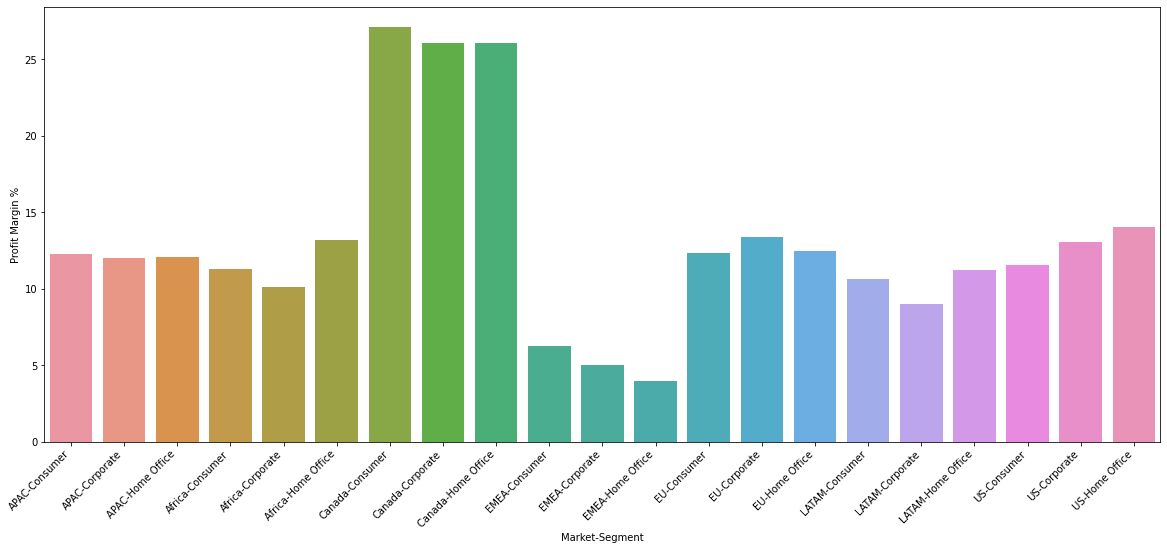

In [18]:
plt.figure(figsize=(20,8))
sns.barplot(x="Market-Segment", y="Profit Margin %", data = dfpm)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

ax.set_title("Profit Margin (%) across Market-Segment", fontsize=18)

ax.set_ylabel("Profit Margin %", fontsize=20)
ax.set_xlabel("Market- Segment", fontsize=20)
plt.show()

#### Inferences:
- 1. The Canada Market has the highest profit margin of above 25% across Consumer, Home Office and Corporate Segments
- 2. The EMEA market is performing the lowest in terms of profit margin

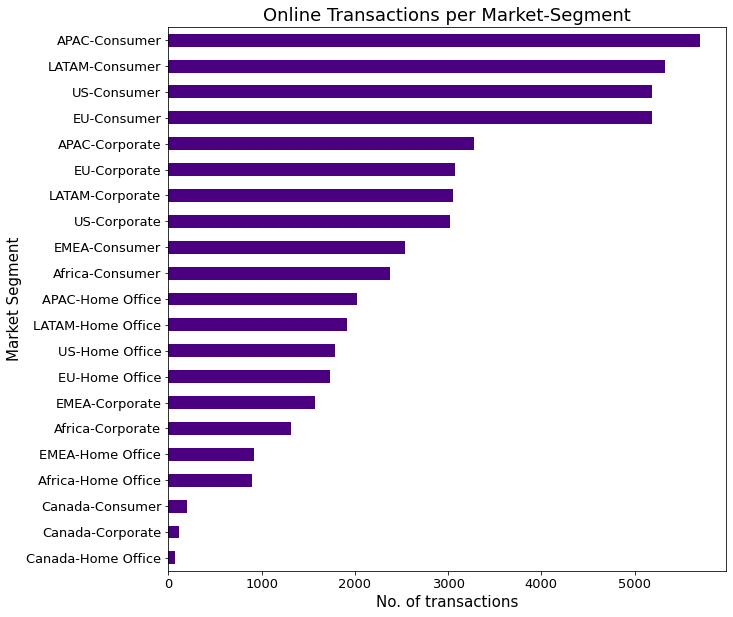

In [19]:
## Visualizing the no. of transactions across 21 Market-Segments

dftr = df_eda.groupby("Market-Segment")["Sales"].count()
dftr.sort_values(ascending=True, inplace=True)

ax = dftr.plot(kind='barh', figsize=(10,10), color = "indigo", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Online Transactions per Market-Segment", fontsize=18)
ax.set_ylabel("Market Segment", fontsize=15)
ax.set_xlabel("No. of transactions", fontsize=15)
plt.show()

#### Inferences:
- 1. The APAC-Consumer received the maximum business transactions, irrespective of sales volume or profit made, followed by LATAM-Consumer.
- 2. The Canada Market received the least business transactions, irrespective of sales volume or profit made.

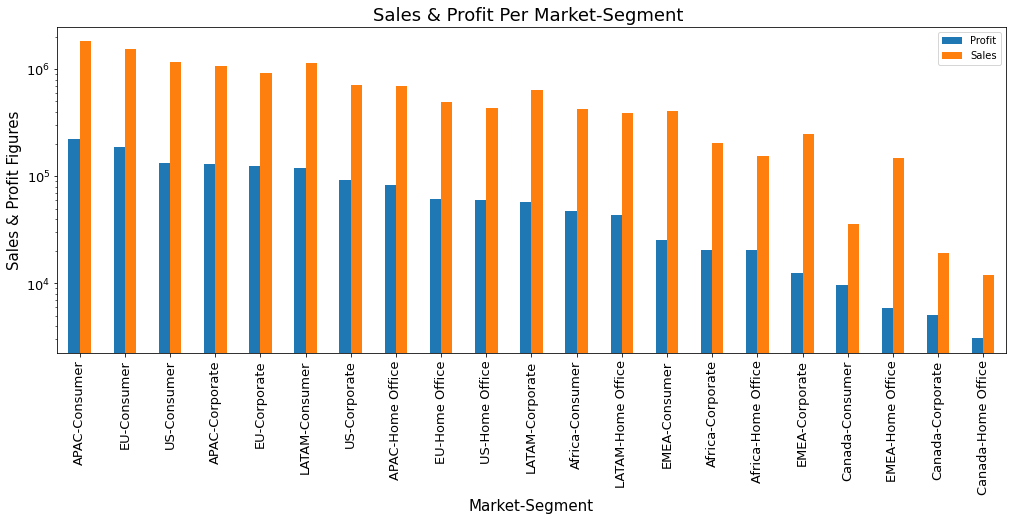

In [20]:
## visualizing the sales and profit figures across 21 market-segments
dfsp = df_eda.groupby("Market-Segment")["Profit", "Sales"].sum().round(2)
dfsp.sort_values(by="Profit", ascending=False, inplace=True)

ax = dfsp.plot(kind='bar', figsize=(17,6),  fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Sales & Profit Per Market-Segment ", fontsize=18)
ax.set_ylabel("Sales & Profit Figures", fontsize=15)
ax.set_xlabel("Market-Segment", fontsize=15)
ax.set_yscale('log')
plt.show()

#### Inferences:
- 1. APAC-Consumer followed by EU-Consumer generated the highest sales (revenue), along with the most profit
- 2. The EMEA-Corporate has performed the worst in terms of hugh sales but far less profits compared to other market-segments.

## Step 3: <u> Monthly Profit Aggregation </u>

### a) Pivot Table to visualize the monthly profit aggregation

In [21]:
## Monthly Aggregation of Profit for each of the 21 market segments
mn_agg= df.pivot_table( index='Order Date',values='Profit', columns='Market-Segment' ,aggfunc='sum')

mn_agg.head()

Market-Segment,APAC-Consumer,APAC-Corporate,APAC-Home Office,Africa-Consumer,Africa-Corporate,Africa-Home Office,Canada-Consumer,Canada-Corporate,Canada-Home Office,EMEA-Consumer,...,EMEA-Home Office,EU-Consumer,EU-Corporate,EU-Home Office,LATAM-Consumer,LATAM-Corporate,LATAM-Home Office,US-Consumer,US-Corporate,US-Home Office
Order Date,,,,,,,,,,,,,,,,,,,,,
2011-01,991.2825,11.5998,86.4423,475.683,219.096,856.710,3.12,5.7,NaN,-2099.364,...,116.400,-845.8290,501.9315,975.360,1976.98976,1150.88400,-106.48800,762.8067,300.9145,1383.0499
2011-02,1338.8688,4358.8254,-417.4128,1441.926,-490.551,820.302,23.31,NaN,87.99,267.060,...,216.690,-1808.1180,2988.4065,-181.041,902.37752,721.25420,300.19936,500.2865,307.2995,58.1420
2011-03,3747.1632,1213.3386,923.7492,322.140,-586.716,67.320,335.55,NaN,84.03,1598.718,...,78.972,2480.5410,736.9890,503.223,2585.17924,39.07512,285.46400,597.2773,333.0515,-431.5989
2011-04,3846.4746,71.0265,657.1080,292.122,776.691,500.136,55.08,NaN,NaN,-300.879,...,-420.090,2496.6405,1056.1785,63.858,387.72148,259.25600,-421.73440,1155.0757,1393.3828,940.3767
2011-05,3639.9423,2534.1672,-272.1717,110.004,241.338,34.926,77.97,NaN,NaN,568.302,...,262.968,254.0805,1586.2740,201.102,1002.34724,-531.74444,-240.11600,698.9171,2063.5013,-23.7088


In [22]:
len(mn_agg)

48

### b) Splitting the dataset into train and test set

In [23]:
## The dataset is composed of 48 months, out of which 42 months are of train set while 6 months are of test set

train_len = 42

train1 = mn_agg[0:train_len] 
test1 = mn_agg[train_len:] 

In [24]:
## Visualizing the first 10 rows of dataframe "Train"
train1.head(10)

Market-Segment,APAC-Consumer,APAC-Corporate,APAC-Home Office,Africa-Consumer,Africa-Corporate,Africa-Home Office,Canada-Consumer,Canada-Corporate,Canada-Home Office,EMEA-Consumer,...,EMEA-Home Office,EU-Consumer,EU-Corporate,EU-Home Office,LATAM-Consumer,LATAM-Corporate,LATAM-Home Office,US-Consumer,US-Corporate,US-Home Office
Order Date,,,,,,,,,,,,,,,,,,,,,
2011-01,991.2825,11.5998,86.4423,475.683,219.096,856.710,3.12,5.70,NaN,-2099.364,...,116.400,-845.8290,501.9315,975.360,1976.98976,1150.88400,-106.48800,762.8067,300.9145,1383.0499
2011-02,1338.8688,4358.8254,-417.4128,1441.926,-490.551,820.302,23.31,NaN,87.99,267.060,...,216.690,-1808.1180,2988.4065,-181.041,902.37752,721.25420,300.19936,500.2865,307.2995,58.1420
2011-03,3747.1632,1213.3386,923.7492,322.140,-586.716,67.320,335.55,NaN,84.03,1598.718,...,78.972,2480.5410,736.9890,503.223,2585.17924,39.07512,285.46400,597.2773,333.0515,-431.5989
2011-04,3846.4746,71.0265,657.1080,292.122,776.691,500.136,55.08,NaN,NaN,-300.879,...,-420.090,2496.6405,1056.1785,63.858,387.72148,259.25600,-421.73440,1155.0757,1393.3828,940.3767
2011-05,3639.9423,2534.1672,-272.1717,110.004,241.338,34.926,77.97,NaN,NaN,568.302,...,262.968,254.0805,1586.2740,201.102,1002.34724,-531.74444,-240.11600,698.9171,2063.5013,-23.7088
2011-06,4328.2596,1435.8294,3452.1018,-1290.639,-259.218,-774.801,7.50,40.08,23.40,-267.030,...,-2371.776,4317.4515,2270.8170,1210.293,1039.27972,2558.46696,643.69764,3486.7664,67.0149,1422.7431
2011-07,1258.9617,525.4647,-42.0498,621.168,134.847,-506.562,47.28,528.33,8.40,-942.603,...,-150.114,760.6920,916.9500,418.935,1906.45620,303.29032,363.28400,-2227.2786,1308.7058,77.0902
2011-08,775.8066,4070.5581,775.7616,232.917,915.885,1090.200,43.68,29.70,NaN,285.270,...,183.276,5498.6715,1626.2670,184.614,1946.89372,180.54028,661.66792,2157.7522,2245.4838,914.8690
2011-09,5181.4449,1952.4675,623.3595,-86.163,950.766,1345.740,134.01,10.17,NaN,1012.101,...,1151.358,5921.8785,5390.6625,2492.901,1632.48620,386.77900,179.39744,8312.1203,-948.1010,964.0801


## Step 4: <u> Coefficient of Variance to find out the most profitable market-segment </u>

In [25]:
CoV = np.std(train1)/np.mean(train1)

cov = pd.DataFrame(CoV)
cov.columns = ["CoV on Profit"]

cov = cov.reset_index()
cov.sort_values(by="CoV on Profit", inplace=True, ascending=True)
cov

,Market-Segment,CoV on Profit
0,APAC-Consumer,0.596404
12,EU-Consumer,0.647485
15,LATAM-Consumer,0.680684
13,EU-Corporate,0.689346
1,APAC-Corporate,0.731926
16,LATAM-Corporate,0.880260
19,US-Corporate,1.027209
2,APAC-Home Office,1.048817
18,US-Consumer,1.095295
14,EU-Home Office,1.114681


### Conclusion:
- The APAC-Consumer has the least CoV means signifies that it is a stable and reliable market out of entire lot and also the most profitable in terms of profit

In [26]:
## Converting the datetime of month-year format to timestamp

df['Order Date'] = df['Order Date'].astype(str)
df['Order Date'] = df['Order Date'].apply(lambda x: pd.Timestamp(x))

### Visualizing the first 10 rows of the original dataframe
df.head()

,Market-Segment,Order Date,Segment,Market,Sales,Profit
30643,LATAM-Consumer,2011-01-01,Consumer,LATAM,60.9600,28.6400
48527,US-Consumer,2011-01-01,Consumer,US,19.3000,5.7900
29861,APAC-Home Office,2011-01-01,Home Office,APAC,51.6285,4.5885
29871,LATAM-Consumer,2011-01-01,Consumer,LATAM,47.9600,15.8000
16508,APAC-Consumer,2011-01-01,Consumer,APAC,176.6808,-156.6792


## Step 5: <u> Creating a new dataframe for APAC-Consumer </u>

In [27]:
## Choosing the most profitable market-segment to perform the forecast and dropping the remaining market-segments
df1 = df[df["Market-Segment"]=="APAC-Consumer"]


In [28]:
df1.head()

,Market-Segment,Order Date,Segment,Market,Sales,Profit
16508,APAC-Consumer,2011-01-01,Consumer,APAC,176.6808,-156.6792
24801,APAC-Consumer,2011-01-01,Consumer,APAC,69.3000,3.4200
16608,APAC-Consumer,2011-01-01,Consumer,APAC,219.9600,8.7600
9787,APAC-Consumer,2011-01-01,Consumer,APAC,337.6395,-122.8005
29891,APAC-Consumer,2011-01-01,Consumer,APAC,30.4560,12.0960


In [29]:
df2 = pd.DataFrame(df1.groupby("Order Date")["Sales"].sum()).round(2)
df2.head()

,Sales
Order Date,
2011-01-01,15711.71
2011-02-01,12910.86
2011-03-01,19472.56
2011-04-01,15440.30
2011-05-01,24348.97


In [30]:
## Checking the attributes of the dataframe
df2.shape

(48, 1)

In [31]:
## Splitting the datasets into train and test to perform the forecasting techniques
train_len = 42
train = df2[0:train_len]
test = df2[train_len:]

## Step 6: <u>Time series Decomposition</u>

### a ) Additive seasonal decomposition

#### The individual components such as trend, seasonality and random noise can be added together to get the original time-series data.
- 1.This type of decomposition is used when residual component do not have any pattern, which means that for every seasonal pattern in the time series, the distance between troughs and peaks remains the same. 

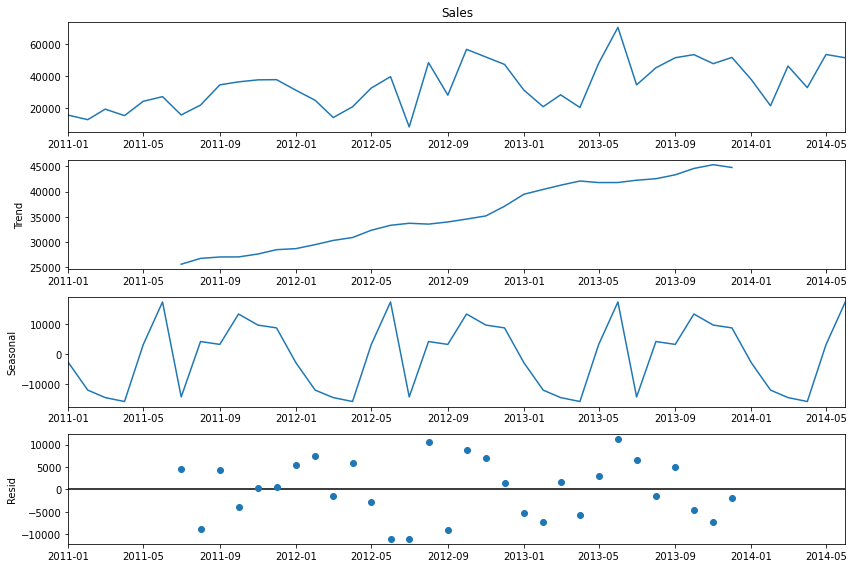

In [32]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(train.Sales, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

#### Inferences:

- 1. The trend component as can be seen from the plot is showing a upward linear trend with some plateaus of non-linearity
- 2. We can see that the seasonal component has similar pattern and relatively constant over time.
- 3. The Residual components are more or less hovering around mean.


### b) Multiplicative seasonal decomposition

#### The individual components such as trend, seasonality and random noise can be multiplied together to get the original time-series data.
- 1. When the seasonal pattern in the data increases with an increase in data values and decrease with decrease in data values

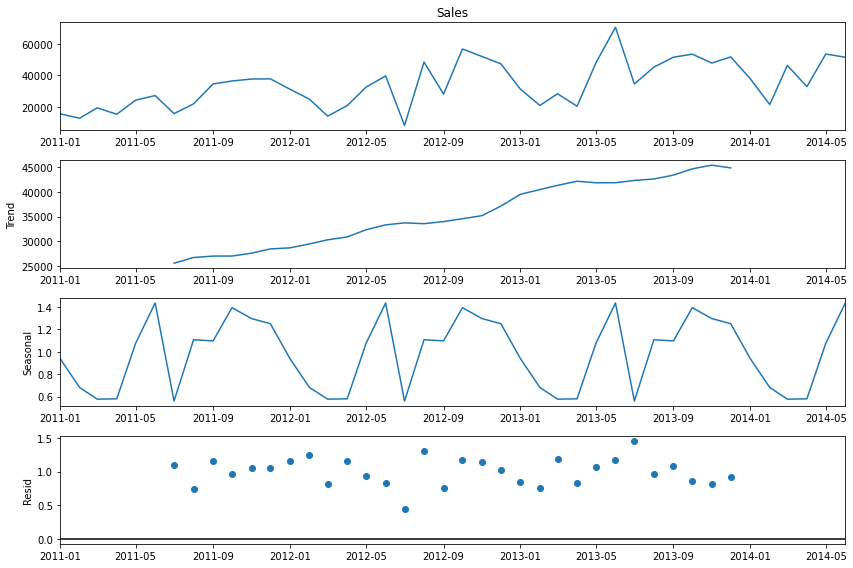

In [33]:
decomposition = sm.tsa.seasonal_decompose(train.Sales, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

#### Inferences:
- 1. The Seasonal component is similar to the one in additive decomposition, which means seasonal pattern is relatively constant over time.
- 2. The trend component is linearly increasing with some plateaus, but there is no non-linear trend in the overall component.

### Conclusion from analyzing the classical decomposition 
- 1. The seasonal component shows that the seasonal period is of 12 months, which means that the pattern repeats itself each year. 
- 2. Due to the presence of linear trend and seasonality, the SARIMA model and Holt's Winter Exponential Smoothing (Additive and Multiplicative) should give better results than the rest of the techniques
- 3. Since, the seasonal component has similar pattern over the entire time series, hence additive trend will have a better hand in terms of forecasting
- 4. Other than few plateus, the trend is increasing linearly upwards and there is no non-linear trend.
- 5. The Residual component do not have any pattern in both additive or multiplicative decomposition plots.

### Types of Forecasting Techniques and their applicability to this dataset
#### Dataset having less than 10 observation:
- 1. <u><b>Naive Method:</b></u> This method works best when there are fewer than 10 observations or data points and also non-noisy data. This is because in naive method, it predicts the next data based on previous data and if there are more than 10 observations, then it undermines or overpredict the forecast values.(This dataset contains more than 10 observations, so naive method can not be applied)


- 2. <u><b>Simple Moving Average Method:</b></u>This works best when there are fewer than 10 observation but data is noisy in nature. It simply averages out all the data points to predict the next value. (This dataset contains more than 10 observations, so simple average moving method can not be applied)


#### Dataset having more than 10 observation:
- 3. <u><b>Simple Exponential Smoothing Method</b></u> When the dataset do not show any trend or seasonality. This method is best used to capture the level component. (This dataset contains more than 10 observation but as it can be seen from time series decomposition, it clearly shows an upward linear trend along with monthly seasonality. Hence, simple exponential smoothing method can be applied but it will not be an optimal method for ths dataset.


- 4. <u><b> Holt's Exponential Smoothing Method</b></u> This method captures both level and trend components of a time series and not the seasonal component. The method will be better than the previous method but still not be optimal method for this dataset as it can not take seasonality into consideration. 


- 5. <u><b> Holt's Winter Exponential Smoothing Method/Additive Seasonal Trend </b></u> This method captures all 3 components of level, trend and seasonality and takes seasonal trend as additive in nature. <b>This method is a good candidate for the optimal forecasting method for this dataset.</b>


- 6. <u><b> Holt's Winter Exponential Smoothing Method/Multiplicative Seasonal Trend </b></u> This method captures all 3 components of level, trend and seasonality and takes seasonal trend as multiplicative in nature. <b>This method is a good candidate for the optimal forecasting method for this dataset.</b>


- 7. <u><b>Auto Regressive Method (AR)</b></u> This method predicts the future observation as linear regression of one or more past observations. It can observe level and trend but do not consider seasonality. Hence, this method can be applied but it will not be an optimal method for ths dataset. 


- 8. <u><b>Moving Average Method (MA)</b></u> TThis Method models the future forecasts using past forecast errors in a regression-like model. It can observe level and trend but do not consider seasonality. Hence, this method can be applied but it will not be an optimal method for ths dataset. 


- 9. <u><b>Auto Regressive Moving Average Method (ARMA)</b></u>This method is a combination of Simple Auto Regression and Moving Average method, as it uses linear regression to predict future observations by using one or more past observations along with past forecast errors.It can observe level and trend but do not consider seasonality. Hence, this method can be applied but it will not be an optimal method for ths dataset. 


- 10. <u><b>Auto Regressive Integrated Moving Average Method (ARIMA)</b></u> The original series is differenced to make it stationary and uses linear regression on past observations and past forecast errors. Along with this, it removes the non-stationarity component called trend and then later integrates the trend to the original series. This method works best to forecast trend and level but not seasonality. Hence, this method can be applied but it will not be an optimal method for ths dataset. 

- 11. <u><b>Seasonal Auto Regressive Integrated Moving Average Method (SARIMA)</b></u> This method captures all the Intricacies of ARIMA model and in addition, captures the seasonality of the time series.SARIMA captures both seasonal and non-seasonal elements of time series (past forecast observations as well as past forecast errors and then it predicts the future.<b>This method is a good candidate for the optimal forecasting method for this dataset.</b>




##  Step 7:<u> Model Building </u>

### I) Smoothing Techniques:


###  <i>Method 1:  Simple Exponential Smoothing </i>

#### This method captures the level component of a time series rather than trend and seasonality, and gives more weightage to the recent observation than past observations

In [34]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train["Sales"])
model_fit = model.fit(smoothing_level=0.9, optimized=True)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses["ses_forecast"] = model_fit.forecast(6)

#### Inferences:
- 1. Since, the value of alpha must lie between 0 and 1, the alpha value of 0.9 is the most efficient to reduce the error terms in MAPE.

### Plot Train, Test and Forecast Set

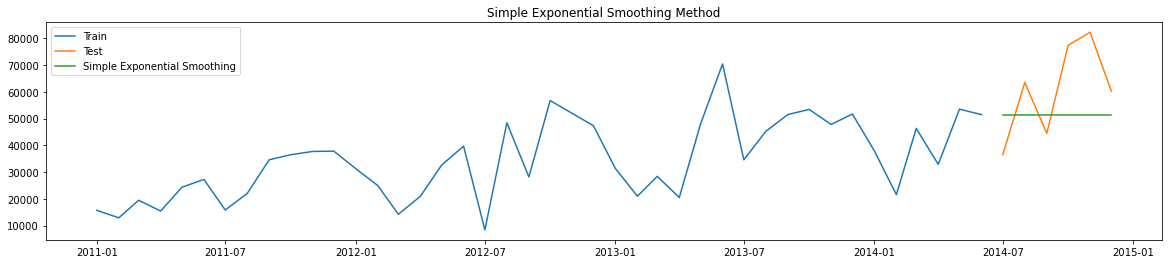

In [35]:
plt.figure(figsize=(20,4))
plt.plot(train["Sales"], label="Train")
plt.plot(test["Sales"], label="Test")
plt.plot(y_hat_ses["ses_forecast"], label="Simple Exponential Smoothing")
plt.legend(loc="best")
plt.title("Simple Exponential Smoothing Method")
plt.show()

#### Inferences:
- 1. This is best to capture level of the time series without any trend or seasonality 
- 2. The green line as seen from the plot has captured the level component but failed to analyze the trend and seasonality

### Measuring RMSE and MAPE

In [36]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test["Sales"], y_hat_ses["ses_forecast"])).round(2)
mape = np.round(np.mean(np.abs(test["Sales"] - y_hat_ses["ses_forecast"])/test["Sales"])*100, 2)

results = pd.DataFrame({"Method": "Simple Exponential Smoothing", "RMSE": [rmse], "MAPE": [mape]})
results = results[["Method", "RMSE", "MAPE"]]
results

,Method,RMSE,MAPE
0,Simple Exponential Smoothing,18768.74,26.86


### <i> Method 2: Holt's Exponential Smoothing </i>
#### This method captures both level and trend components of a time series and not the seasonal component

In [37]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train["Sales"]), seasonal_periods=12, trend="additive", seasonal=None)
model_fit = model.fit(smoothing_level = 0.9, smoothing_slope = 0.2, optimized=True)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt["holt_forecast"] = model_fit.forecast(6)

{'smoothing_level': 0.9, 'smoothing_slope': 0.2, 'smoothing_seasonal': nan, 'damping_slope': nan, 'initial_level': 13991.939481862923, 'initial_slope': 1278.5558629896868, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot Train, Test and Forecast Set

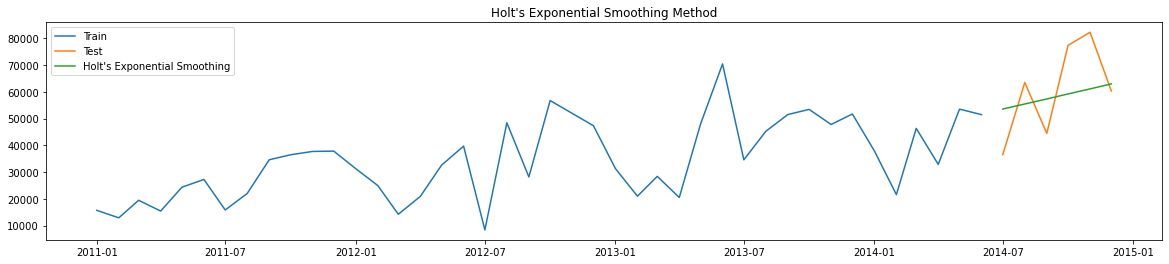

In [38]:
plt.figure(figsize=(20,4))
plt.plot(train["Sales"], label="Train")
plt.plot(test["Sales"], label="Test")
plt.plot(y_hat_holt["holt_forecast"], label="Holt's Exponential Smoothing")
plt.legend(loc="best")
plt.title("Holt's Exponential Smoothing Method")
plt.show()

#### Inferences:
- This method is best suited for those dataset having level and trend component but no seasonality
- The green line as shown in the plot above has ignored the seasonal nature but captured the upward trend and level.
- The smoothing_slope is taken as 0.2, because the more slope weightage has been given to the few recent observation.
- The lower the value of smoothing_slope, say 0.01 will equal importance to the all the observation, is better when predicting for longer period of time.
- As we are just predicting for the next 6 months, we have used a higher smoothing_slope of 0.2

### Measuring RMSE and MAPE

In [39]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test["Sales"], y_hat_holt["holt_forecast"])).round(2)
mape = np.round(np.mean(np.abs(test["Sales"] - y_hat_holt["holt_forecast"])/test["Sales"])*100, 2)

tempResults = pd.DataFrame({"Method":["Holt's Exponential Smoothing"], "RMSE":[rmse], "MAPE": [mape]})
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Simple Exponential Smoothing,18768.74,26.86
0,Holt's Exponential Smoothing,14760.65,23.67


### <i> Method 3: Holt's Winter Exponential Smoothing / Additive Seasonal Trend </i>

#### This method captures all three components of trend, seasonality and level where the seasonal trend will be additive in nature.

#### Note: 
- 1. The dataset that we have is about monthly sales from a global online store and there is always a trend by which consumers buy products online. For. e.g., there might be end of fiscal year, summer and winter holidays, festivals like Christmas or Diwali etc.
- 2. The behaviour of consumers is driven by all the above factors and help them decide when they should buy a particular product. This repeated pattern provides a foundation to the additive seasonal trend.

In [40]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train["Sales"]), seasonal_periods = 12, trend="add", seasonal="add")
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa["hwa_forecast"] = model_fit.forecast(6)

{'smoothing_level': 0.052631578947367676, 'smoothing_slope': 0.05263157894736842, 'smoothing_seasonal': 0.10526315789474947, 'damping_slope': nan, 'initial_level': 29061.28999999959, 'initial_slope': 730.4168055555452, 'initial_seasons': array([-13349.58, -16150.43,  -9588.73, -13620.99,  -4712.32,  -1801.27,
       -13218.46,  -7049.05,   5551.89,   7410.76,   8661.31,   8785.7 ]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot Train, Test and Forecast Set

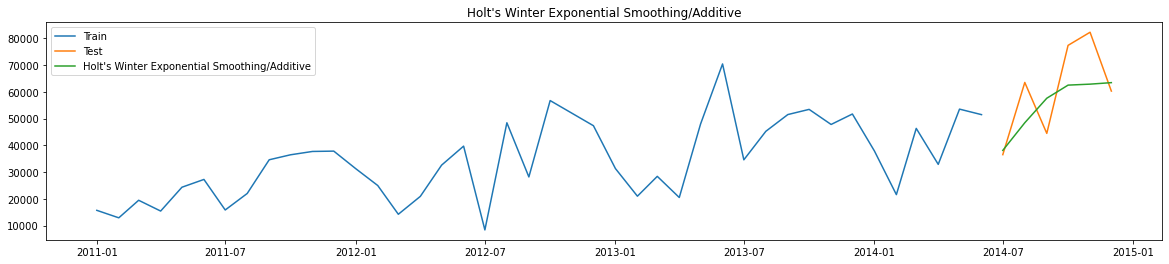

In [41]:
plt.figure(figsize=(20,4))
plt.plot(train["Sales"], label="Train")
plt.plot(test["Sales"], label="Test")
plt.plot(y_hat_hwa["hwa_forecast"], label="Holt's Winter Exponential Smoothing/Additive")
plt.legend(loc="best")
plt.title("Holt's Winter Exponential Smoothing/Additive")
plt.show()

### Measuring RMSE and MAPE

In [42]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test["Sales"], y_hat_hwa["hwa_forecast"])).round(2)
mape = np.round(np.mean(np.abs(test["Sales"] - y_hat_hwa["hwa_forecast"])/test["Sales"])*100, 2)

tempResults = pd.DataFrame({"Method":["Holt's Winter Exponential Smoothing/Additive"], "RMSE":[rmse], "MAPE": [mape]})
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Simple Exponential Smoothing,18768.74,26.86
0,Holt's Exponential Smoothing,14760.65,23.67
0,Holt's Winter Exponential Smoothing/Additive,12971.01,17.61


#### Inferences:
- 1. The model is able to capture level and trend component efficiently, but could not predict the seasonality efficiently

### </i> Method 4: Holt's Winter Exponential Smoothing / Multiplicative Seasonal Trend </i>

#### This method captures all three components of trend, seasonality and level where the seasonal trend will be multiplicative in nature.

#### Note: 
- 1. The dataset that we have is about monthly sales from a global online store and there is always a trend by which consumers buy products online. For. e.g., there might be end of fiscal year, summer and winter holidays, festivals like Christmas or Diwali etc.
- 2. The behaviour of consumers is driven by all the above factors and help them decide when they should buy a particular product and due to the less volatile nature of consumers, multiplicative seasonal trend might be less efficient than additive seasonal trend.

In [43]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train["Sales"]), seasonal_periods = 12, trend="add", seasonal="mul")
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa["hwa_forecast"] = model_fit.forecast(6)

{'smoothing_level': 0.05263157894736842, 'smoothing_slope': 0.05263157894736842, 'smoothing_seasonal': 0.21052631578947367, 'damping_slope': nan, 'initial_level': 29061.29, 'initial_slope': 730.4168055555556, 'initial_seasons': array([0.54064049, 0.44426314, 0.67005147, 0.53130126, 0.8378489 ,
       0.93801824, 0.54515233, 0.75744194, 1.19104073, 1.25500451,
       1.29803598, 1.30231624]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot Train, Test and Forecast Set

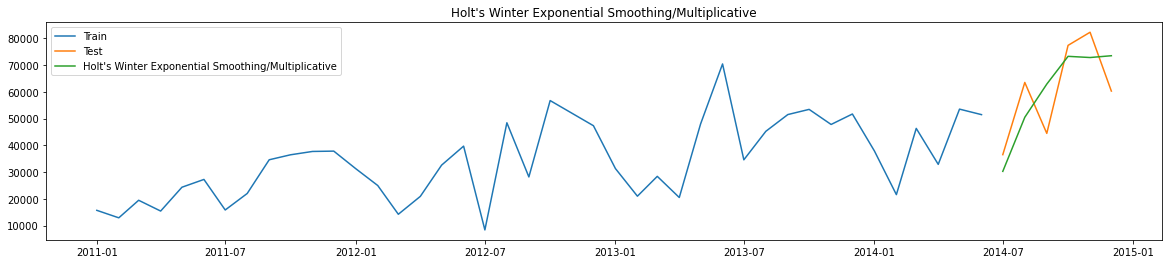

In [44]:
plt.figure(figsize=(20,4))
plt.plot(train["Sales"], label="Train")
plt.plot(test["Sales"], label="Test")
plt.plot(y_hat_hwa["hwa_forecast"], label="Holt's Winter Exponential Smoothing/Multiplicative")
plt.legend(loc="best")
plt.title("Holt's Winter Exponential Smoothing/Multiplicative")
plt.show()

### Measuring RMSE and MAPE

In [45]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test["Sales"], y_hat_hwa["hwa_forecast"])).round(2)
mape = np.round(np.mean(np.abs(test["Sales"] - y_hat_hwa["hwa_forecast"])/test["Sales"])*100, 2)

tempResults = pd.DataFrame({"Method":["Holt's Winter Exponential Smoothing/Multiplicative"], "RMSE":[rmse], "MAPE": [mape]})
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Simple Exponential Smoothing,18768.74,26.86
0,Holt's Exponential Smoothing,14760.65,23.67
0,Holt's Winter Exponential Smoothing/Additive,12971.01,17.61
0,Holt's Winter Exponential Smoothing/Multiplica...,11753.42,19.62


#### Inferences:
- 1. This method has performed well in predicting the trend and level component but could not predict the seasonality of the time series effectively.

### II) ARIMA Techniques

### Pre-requisites before implementing ARIMA set of forecasting techniques:
- 1. Check whether the time series is of stationary or non-stationary nature
- 2. Apply ADF and KPSS Test to check whether the time series is stationary or not.
- 3. Apply boxcox transformation to make the variance constant and differencing to make the trend constant

### <i> <u> Stationary vs Non-Stationary Time Series </u> </i>

- a) A time series is said to be <b>stationary</b> in nature if its mean, variance and covariance are same throughout the entire time period, irrespective of where you observe it.

- b) If one of the factors like mean, variance or covariance is constant, then we will say that the time series is <b>non-stationary</b> in nature.

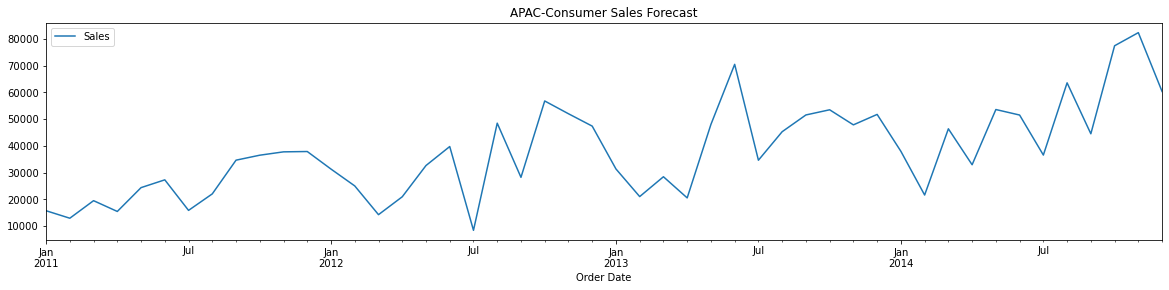

In [46]:
### Plotting how the sales is spread out across 48 months
df2['Sales'].plot(figsize=(20, 4))

plt.legend(loc='best')
plt.title('APAC-Consumer Sales Forecast')
plt.show(block=False)

### <i><u> Stationarity Tests : To check whether we need Boxcox Transformation and Differencing </u> </i>

### 1) Augmented Dickey Fuller Test
- #### Null Hypothesis (H0): The series is not stationary
- p > 0.05
- #### Alternate Hypothesis (H1): The series is stationary
- p <= 0.05

In [47]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df2['Sales'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -2.220857
Critical Values @ 0.05: -2.93
p-value: 0.198763


#### Inference:
- The p-value of 0.19873 is higher than the critical threshold of 0.05, which means we will accept the null hypothesis stating that the series is not stationary in nature

### 2) Kwiatkowski-Phillips-Schmidt-Shinn(KPSS) Test
- #### Null Hypothesis (H0): The series is stationary
- p > 0.05
- #### Alternate Hypothesis (H1): The series is not stationary
- p <= 0.05

In [48]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(df2['Sales'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.595515
Critical Values @ 0.05: 0.46
p-value: 0.023044


#### Inference:
- The p-value of 0.023044 is lower than the critical threshold of 0.05, which means we failed to accept the null hypothesis and will accept the alternate hypothesis that the series is not stationary

### Steps for converting non-stationary time series to stationary
- 1. Boxcox Transformation
- 2. Differencing

### <i>Boxcox Transformation to make variance constant</i>

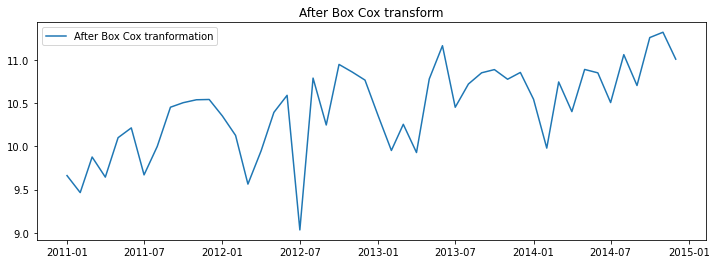

In [49]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(df2['Sales'], lmbda=0), index = df2.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

### <i>Differencing to remove trend</i>

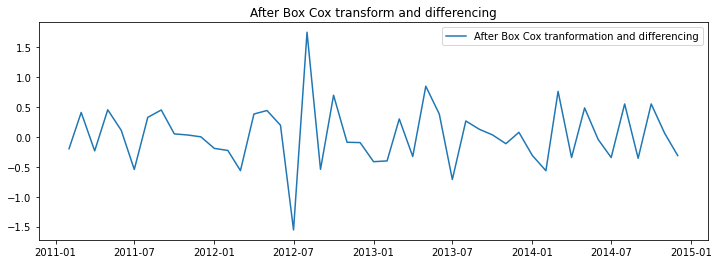

In [50]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), df2.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [51]:
data_boxcox_diff.dropna(inplace=True)

### <i><u>Stationary Tests: After Boxcox Transformation and Differencing</u></i>

### 1) Augmented Dickey Fuller Test
- #### Null Hypothesis (H0): The series is not stationary
- p > 0.05
- #### Alternate Hypothesis (H1): The series is stationary
- p <= 0.05

In [52]:
adf_test = adfuller(data_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -5.769275
Critical Values @ 0.05: -2.95
p-value: 0.000001


#### Inferences:
- The p-value of 0.000001 is less than the critical threshold of 0.05, which means we failed to accept the null hypothesis and will accept the alternate hypothesis which states that the series is now stationary

### 2) Kwiatkowski-Phillips-Schmidt-Shinn(KPSS) Test
- #### Null Hypothesis (H0): The series is stationary
- p > 0.05
- #### Alternate Hypothesis (H1): The series is not stationary
- p <= 0.05

In [53]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.135659
Critical Values @ 0.05: 0.46
p-value: 0.100000


#### Inferences:
- The p-value of 0.1 is higher than the critical threshold of 0.05, which means we will accept the null hypothesis signifying that the series is stationary

### Conclusion from Stationary Tests:
- After the transformation and differencing, the non-stationary series has become stationary series, which means it is now ready to used for forecasting using ARIMA Techiques

In [54]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

In [55]:
len(train_data_boxcox)

42

### II) ARIMA Techniques

### Method 5: Auto Regression Method
#### This method predicts the future observation as linear regression of one or more past observations

In [56]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

const      0.031320
ar.L1.y   -0.483978
dtype: float64


- We have used lag order, p = 1, which is no. of lags used to build 'p' number of past datapoints in order to predict future datapoints

### Recovering original Time Series

In [57]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

### Plot Train, Test and Forecast Set

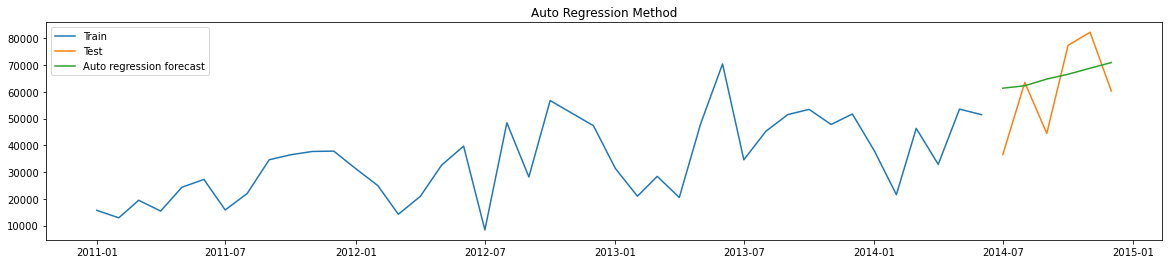

In [58]:
plt.figure(figsize=(20,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

### Measuring RMSE and MAPE

In [59]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ar['ar_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple Exponential Smoothing,18768.74,26.86
0,Holt's Exponential Smoothing,14760.65,23.67
0,Holt's Winter Exponential Smoothing/Additive,12971.01,17.61
0,Holt's Winter Exponential Smoothing/Multiplica...,11753.42,19.62
0,Autoregressive (AR) method,15505.02,27.27


#### Inferences:
- The AR Method performed well as it was able to capture the increasing linear trend but could not capture the seasonal component of the time series.
- The AR method having MAPE value of 27.27 and RMSE of 15505.02 has performed slightly better than simple exponential smoothing, which signifies that it has able to capture the level component efficiently

### Method 6: Moving average method (MA)
#### This Method models the future forecasts using past forecast errors in a regression-like model. This model has a parameter ‘q’ called window size over which linear combination of errors are calculated.

In [60]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 1)) 
model_fit = model.fit()
print(model_fit.params)

const      0.022694
ma.L1.y   -1.000000
dtype: float64


 - We have used window size, q = 1, to predict future based on the linear combinations of past errors.

### Recover original time series

In [61]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

### Plot train, test and forecast

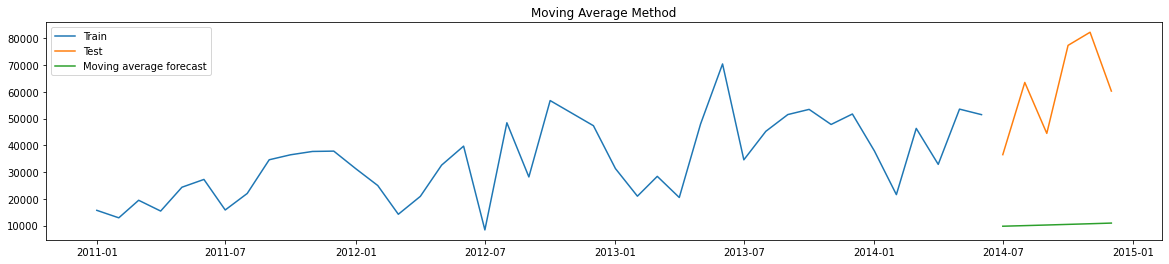

In [62]:
plt.figure(figsize=(20,4))
plt.plot(df2['Sales'][:train_len], label='Train')
plt.plot(df2['Sales'][train_len:], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

### Measuring RMSE and MAPE

In [63]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ma['ma_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple Exponential Smoothing,18768.74,26.86
0,Holt's Exponential Smoothing,14760.65,23.67
0,Holt's Winter Exponential Smoothing/Additive,12971.01,17.61
0,Holt's Winter Exponential Smoothing/Multiplica...,11753.42,19.62
0,Autoregressive (AR) method,15505.02,27.27
0,Moving Average (MA) method,52903.36,81.64


#### Inferences:
- The MA Method failed to capture either trend or seasonality of this time series
- The MAPE value of 81.64 and RMSE of 52903.36 clearly shows that the error values are huge in this method.

### Method 7: Auto regression moving average method (ARMA)

#### This method is a combination of Simple Auto Regression and Moving Average method, as it uses linear regression to predict future observations by using one or more past observations along with past forecast errors

In [64]:
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.params)

const      0.022811
ar.L1.y    0.115926
ma.L1.y   -0.999929
dtype: float64


### Recover original time series

In [65]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

### Plot train, test and forecast

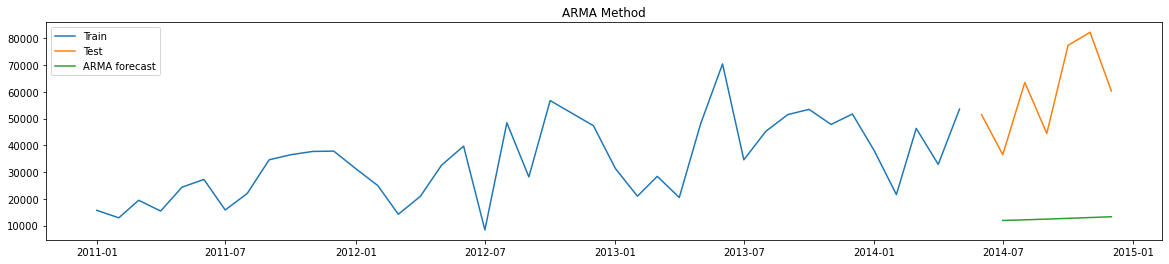

In [66]:
plt.figure(figsize=(20,4))
plt.plot( df2['Sales'][:train_len-1], label='Train')
plt.plot(df2['Sales'][train_len-1:], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Method')
plt.show()

### Measuring RMSE and MAPE

In [67]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_arma['arma_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arma['arma_forecast'][train_len-1:])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive moving average (ARMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple Exponential Smoothing,18768.74,26.86
0,Holt's Exponential Smoothing,14760.65,23.67
0,Holt's Winter Exponential Smoothing/Additive,12971.01,17.61
0,Holt's Winter Exponential Smoothing/Multiplica...,11753.42,19.62
0,Autoregressive (AR) method,15505.02,27.27
0,Moving Average (MA) method,52903.36,81.64
0,Autoregressive moving average (ARMA) method,50753.72,77.65


#### Inferences:
- The ARMA method failed to capture the seasonal pattern of this time series
- The MAPE Value of 77.65 and RMSE of 50753.72 shows that this model performed poorly.

### Method 8: Auto regressive integrated moving average (ARIMA)
#### This method works best to predict level and trend but no seasonality
- Note: The original series is differenced to make it stationary and uses linear regression on past observations and past forecast errors. Along with this, it removes the non-stationarity component called trend and then later integrates the trend to the original series

In [68]:
model = ARIMA(train_data_boxcox, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.params)

const        0.022811
ar.L1.D.y    0.115926
ma.L1.D.y   -0.999929
dtype: float64


### Recover original time series forecast

In [69]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

### Plot train, test and forecast

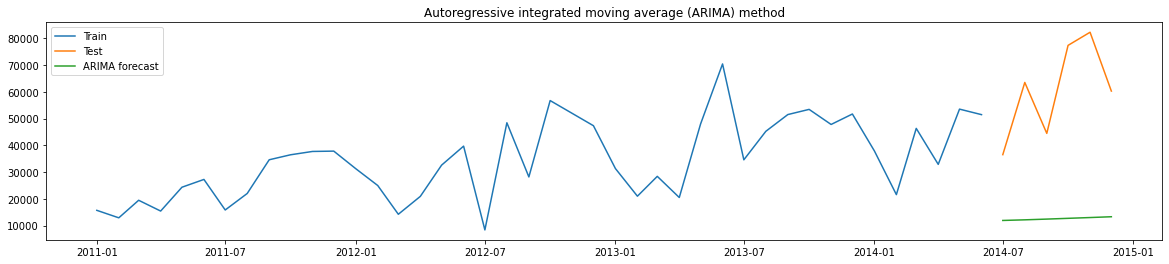

In [70]:
plt.figure(figsize=(20,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

### Measuring RMSE and MAPE

In [71]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arima['arima_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple Exponential Smoothing,18768.74,26.86
0,Holt's Exponential Smoothing,14760.65,23.67
0,Holt's Winter Exponential Smoothing/Additive,12971.01,17.61
0,Holt's Winter Exponential Smoothing/Multiplica...,11753.42,19.62
0,Autoregressive (AR) method,15505.02,27.27
0,Moving Average (MA) method,52903.36,81.64
0,Autoregressive moving average (ARMA) method,50753.72,77.65
0,Autoregressive integrated moving average (ARIM...,50753.72,77.65


#### Inferences:
- The ARIMA method failed to capture the seasonal pattern of this time series
- The MAPE Value of 77.65 and RMSE of 50753.72 shows that this model performed poorly.
- The ARIMA method performed exactly similar to the ARMA method.

### Method 9: Seasonal auto regressive integrated moving average (SARIMA)
#### This method captures all the Intracacies of ARIMA model and in addition, captures the seasonality of the time series.

#### Note:
#### The non-seasonal elements of SARIMA
- 1. Time series is differenced to make it stationary.
- 2. Models future observation as linear regression of past observations and past forecast errors.

#### The seasonal elements of SARIMA

- 1. Perform seasonal differencing on time series.
- 2. Model future seasonality as linear regression of past observations of seasonality and past forecast errors of seasonality.



In [72]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()
print(model_fit.params)

ar.L1      -0.100671
ma.L1      -0.991130
ar.S.L12   -0.395675
ma.S.L12   -0.979526
sigma2      0.047762
dtype: float64


### Recover original time series forecast

In [73]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

### Plot train, test and forecast

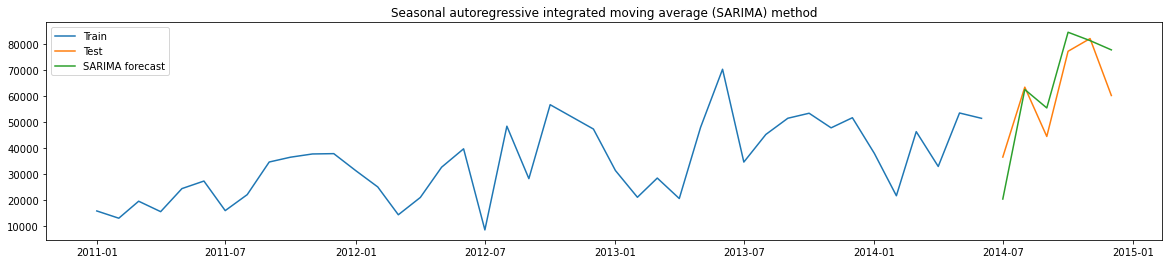

In [74]:
plt.figure(figsize=(20,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

#### Inferences:
- The SARIMA method is able to capture both trend and seasonality during the forecast period and performs better in terms of prediction

### Measuring RMSE and MAPE

In [75]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results.reset_index(drop=True, inplace=True)
results

,Method,RMSE,MAPE
0,Simple Exponential Smoothing,18768.74,26.86
1,Holt's Exponential Smoothing,14760.65,23.67
2,Holt's Winter Exponential Smoothing/Additive,12971.01,17.61
3,Holt's Winter Exponential Smoothing/Multiplica...,11753.42,19.62
4,Autoregressive (AR) method,15505.02,27.27
5,Moving Average (MA) method,52903.36,81.64
6,Autoregressive moving average (ARMA) method,50753.72,77.65
7,Autoregressive integrated moving average (ARIM...,50753.72,77.65
8,Seasonal autoregressive integrated moving aver...,11181.65,18.38


### Conclusion:
- Under Smoothing Techniques, the Holt's Winter Exponential Smoothing/Additive seasonal trend is the most efficient with minimum error values. (MAPE = 17.61 and RMSE = 12971.01)


- Under ARIMA Techniques, the SARIMA method is the most efficient with minimum error terms and best method in predicting all the three components of level, trend and seasonality. (MAPE = 18.38 and RMSE = 11181.65)